In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [4]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [5]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

In [6]:
from narrative import nar181026_heat_confidence_genes

from narrative import nar181205_networks

In [7]:
from scipy.stats import spearmanr

In [8]:
save_images = False

In [9]:
limes = [2, 4.5]

In [10]:
outfolder = '211007_visualize_imbalance_and_significant_genes_cds'

In [11]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [12]:

pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: cds_SumACGT']].rename(columns={
    'Genbank_validated_RNA: cds_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [13]:
from natsort import natsorted

In [14]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 


de_set = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') & 
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))

]



In [15]:
from itertools import product

In [16]:
onditions = natsorted(de_set['condition'].unique())
ages = de_set['older'].unique()
out = pd.DataFrame(index=tissues_to_consider, columns=ages)


for tissue, age in product(tissues_to_consider, ages):

    d = de_set[
        (de_set['older']==age) &
        (de_set['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[tissue, age] = r

In [17]:
out.loc[out.loc[:, 24]<0, 24].sort_values().rank(pct=True)

Blood        0.076923
Kidney       0.153846
SI           0.230769
LI           0.307692
Stomach      0.384615
BAT          0.461538
Esophagus    0.538462
GutEP        0.615385
Adrenal      0.692308
Heart        0.769231
MuscSat      0.846154
WAT          0.923077
Liver        1.000000
Name: 24.0, dtype: float64

In [18]:
out.loc[out.loc[:, 24]<0, 24].sort_values()

Blood        -0.614577
Kidney       -0.592909
SI           -0.592724
LI           -0.465375
Stomach       -0.43432
BAT          -0.340043
Esophagus    -0.297564
GutEP        -0.215643
Adrenal      -0.168361
Heart        -0.162407
MuscSat      -0.111891
WAT         -0.0924049
Liver        -0.064182
Name: 24.0, dtype: object

In [19]:
from natsort import natsorted

In [20]:
conditions = natsorted(all_de['condition'].unique())

In [21]:
condition = 'Esophagus_0_4_24'

In [22]:
d = all_de[
    (all_de['condition']==condition) & 
    (all_de['is_detected']==True) & 
    (all_de['de_unit']=='both') & 
    (all_de['gene_ncbi'].isin(ref_genes))
]

In [23]:
e = pd.merge(d[['gene_ncbi', 'o_over_y', 'padj']], pr[['gene_ncbi', 'log_length']])

In [24]:
e.loc[:, 'is_significant'] = e['padj'] < 0.05

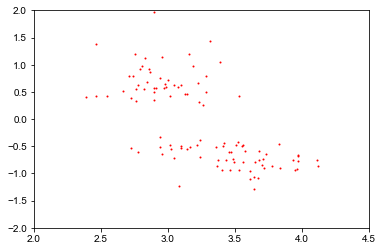

In [25]:

f = e['padj'] < 0.05
plt.scatter(
    e.loc[f, 'log_length'], e.loc[f, 'o_over_y'], c='red', s=1)

plt.ylim([-2, 2])
plt.xlim(limes)

if save_images:
    export.export_image(
        f'{outfolder}/sole_scatter.pdf')




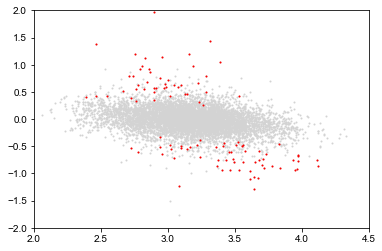

In [26]:
plt.scatter(
    e.loc[:, 'log_length'], e.loc[:, 'o_over_y'], c='lightgrey', s=1)


f = e['padj'] < 0.05
plt.scatter(
    e.loc[f, 'log_length'], e.loc[f, 'o_over_y'], c='red', s=1)

plt.ylim([-2, 2])
plt.xlim(limes)

if save_images:
    export.export_image(
        f'{outfolder}/light_scatter.pdf')



In [27]:
e.corr('spearman')

,gene_ncbi,o_over_y,padj,log_length,is_significant
gene_ncbi,1.000000,0.011174,0.068809,0.140552,-0.057328
o_over_y,0.011174,1.000000,0.058098,-0.297564,-0.024417
padj,0.068809,0.058098,1.000000,-0.019888,-0.212990
log_length,0.140552,-0.297564,-0.019888,1.000000,0.020831
is_significant,-0.057328,-0.024417,-0.212990,0.020831,1.000000


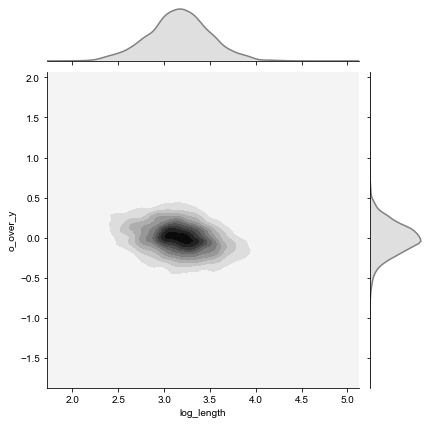

In [28]:
sns.jointplot(x='log_length', y='o_over_y', data=e, kind='kde',color='grey')

if save_images:
    export.export_image(
        f'{outfolder}/grey.pdf')



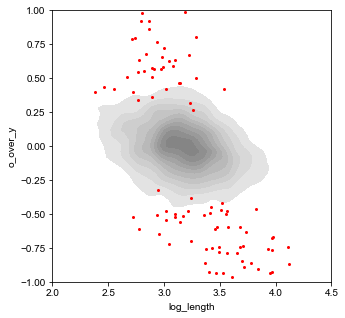

In [29]:
plt.figure(figsize=(5, 5))

sns.kdeplot(
    e.loc[:, 'log_length'], e.loc[:, 'o_over_y'], color='gray',shade=True, shade_lowest=False)


f = e['padj'] < 0.05
plt.scatter(
    e.loc[f, 'log_length'], e.loc[f, 'o_over_y'], c='red', s=4)

plt.ylim([-1, 1])
plt.xlim(limes)

if save_images:
    export.export_image(
        f'{outfolder}/hybrid_scatter.pdf')




In [31]:
e['up'] = e['o_over_y']>0

In [32]:
e[f]['up'].value_counts()

False    58
True     46
Name: up, dtype: int64